In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("Daily_Demand_Forecasting_Orders.csv", sep=";")
data.head(10)
y = pd.DataFrame(data.iloc[:,-1])
data.drop(data.columns[-1], axis=1, inplace=True)
display(data.head(10))
display(y.head(10))

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257
5,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966
6,2,5,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,48269,20973
7,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502
8,3,2,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458
9,3,3,146.518,101.045,36.399,43.306,168.723,865.000,58224,7742,82395,11948


,Target (Total orders)
0,539.577
1,224.675
2,129.412
3,317.120
4,210.517
5,207.364
6,263.043
7,248.958
8,344.291
9,248.428


In [3]:
data.describe()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3)
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,3.016667,4.033333,172.554933,118.920850,52.112217,109.229850,139.531250,77.396133,44504.350000,46640.833333,79401.483333,23114.633333
std,1.282102,1.401775,69.505788,27.170929,18.829911,50.741388,41.442932,186.502470,12197.905134,45220.736293,40504.420041,13148.039829
min,1.000000,2.000000,43.651000,77.371000,21.826000,25.125000,74.372000,0.000000,11992.000000,3452.000000,16411.000000,7679.000000
25%,2.000000,3.000000,125.348000,100.888000,39.456250,74.916250,113.632250,1.243250,34994.250000,20130.000000,50680.500000,12609.750000
50%,3.000000,4.000000,151.062500,113.114500,47.166500,99.482000,127.990000,7.831500,44312.000000,32527.500000,67181.000000,18011.500000
75%,4.000000,5.000000,194.606500,132.108250,58.463750,132.171000,160.107500,20.360750,52111.750000,45118.750000,94787.750000,31047.750000
max,5.000000,6.000000,435.304000,223.270000,118.178000,267.342000,302.448000,865.000000,71772.000000,210508.000000,188411.000000,73839.000000


In [4]:
# apply onehot encoding to week and day numbers.
enc = OneHotEncoder(sparse=False)
dates = data.iloc[:,[0,1]]
encoded = enc.fit_transform(dates)
df_to_add = pd.DataFrame(encoded, columns=["W1", "W2", "W3", "W4", "W5", "Mon", "Tue", "Wed", "Thu", "Fri"])
# create new data frame by adding one-hot encoded data.
data_encoded = pd.concat([df_to_add, data.iloc[:, 2:]], axis=1)
data_encoded.head(10)

,W1,W2,W3,W4,W5,Mon,Tue,Wed,Thu,Fri,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,48269,20973
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502
8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458
9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,146.518,101.045,36.399,43.306,168.723,865.000,58224,7742,82395,11948


### Linear Model
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.get_params

MSE of the linear regressor: 0.000
R2 of the linear regressor: 1.000


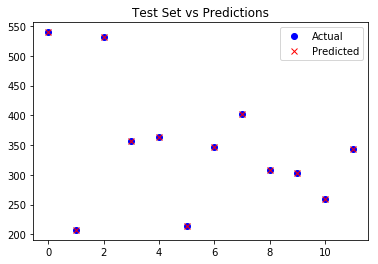

In [5]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression(fit_intercept=True)
X_train, X_test, y_train, y_test = train_test_split(data_encoded, y, test_size=0.2, random_state=42)
linear_reg = LinearRegression(fit_intercept=True)
linear_reg.fit(X_train, y_train)
linear_reg_y = pd.DataFrame(linear_reg.predict(X_test), columns=[y.columns[0]]) 
print("MSE of the linear regressor: {:.3f}".format(mean_squared_error(y_test, linear_reg_y)))
print("R2 of the linear regressor: {:.3f}".format(r2_score(y_test, linear_reg_y)))
x = list(range(y_test.shape[0]))
plt.plot(x, y_test, "bo")
plt.plot(x, linear_reg_y, "rx")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])

Linear model shows a typical overfitting characteristics.
In order to prevent overfitting, regularization might be helpfull. Ridge regression adds regularization term.
### Ridge Regression
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

Regularization term: 0.1
MSE of the ridge regression regressor: 0.002
R2 of the ridge regression regressor: 1.000


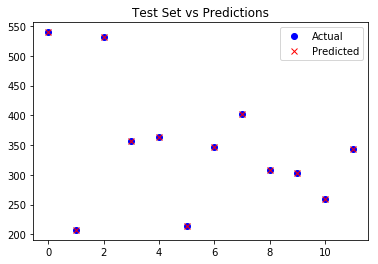

In [6]:
from sklearn.linear_model import RidgeCV
ridge_reg = RidgeCV(alphas=[0.1, 1, 10], fit_intercept=True)
ridge_reg.fit(X_train, y_train)
print("Regularization term: {}".format(ridge_reg.alpha_))
ridge_reg_y = pd.DataFrame(ridge_reg.predict(X_test), columns=[y.columns[0]])
print("MSE of the ridge regression regressor: {:.3f}".format(mean_squared_error(y_test, ridge_reg_y)))
print("R2 of the ridge regression regressor: {:.3f}".format(r2_score(y_test, ridge_reg_y)))
x = list(range(y_test.shape[0]))
plt.plot(x, y_test, "bo")
plt.plot(x, ridge_reg_y, "rx")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])

Ridge regression shows overfitting characteristics too.
### Decision Tree Regressor

In [7]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
# dt_reg.get_params()
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
loo = LeaveOneOut()

Best parameters: {'min_samples_leaf': 8}
MSE of the decision tree regressor: 5279.286
R2 of the decision tree regressor: 0.484


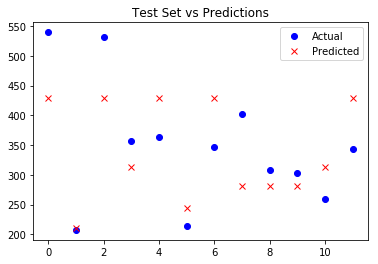

In [8]:
param_grid = {"min_samples_leaf":list(range(2, 9))}
grid_search = GridSearchCV(estimator=dt_reg, 
                           param_grid=param_grid, 
                           scoring=make_scorer(mean_squared_error), 
                           n_jobs=-1, 
                           cv=loo, 
                           refit=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
dt_reg_y = pd.DataFrame(grid_search.predict(X_test), columns=[y.columns[0]])
print("MSE of the decision tree regressor: {:.3f}".format(mean_squared_error(y_test, dt_reg_y)))
print("R2 of the decision tree regressor: {:.3f}".format(r2_score(y_test, dt_reg_y)))
x = list(range(y_test.shape[0]))
plt.plot(x, y_test, "bo")
plt.plot(x, dt_reg_y, "rx")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])

### Random Forest
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Best parameters: {'min_samples_leaf': 8}
MSE of the random forest regressor: 5966.307
R2 of the random forest regressor: 0.417


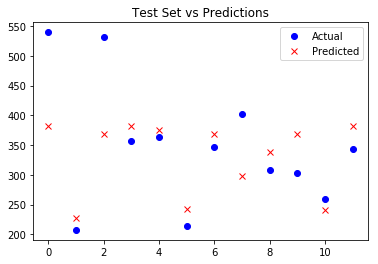

In [9]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
# rf_reg.get_params()
param_grid = {"min_samples_leaf": list(range(2, 9))}
grid_search = GridSearchCV(estimator=rf_reg, 
                           param_grid=param_grid, 
                           scoring=make_scorer(mean_squared_error), 
                           n_jobs=-1, 
                           cv=loo, 
                           refit=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
rf_reg_y = pd.DataFrame(grid_search.predict(X_test), columns=[y.columns[0]])
print("MSE of the random forest regressor: {:.3f}".format(mean_squared_error(y_test, rf_reg_y)))
print("R2 of the random forest regressor: {:.3f}".format(r2_score(y_test, rf_reg_y)))
x = list(range(y_test.shape[0]))
plt.plot(x, y_test, "bo")
plt.plot(x, rf_reg_y, "rx")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])

### MLP Regressor
Ref: http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
MSE of the mlp regressor: 248339.773
R2 of the mlp regressor: -23.263


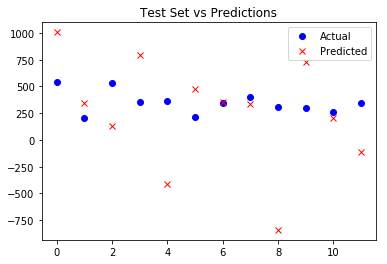

In [10]:
from sklearn.neural_network import MLPRegressor
mlp_reg = MLPRegressor()
# mlp_reg.get_params()
X_train, X_test, y_train, y_test = train_test_split(data_encoded, y, test_size=0.2, random_state=42)
param_grid = {"hidden_layer_sizes": [(100,), (200,), (300,), (400,), (500,), (600,), (700,), (800,), (900,), (1000,)], 
              "alpha": [0.001, 0.0001, 0.00001]}
grid_search = GridSearchCV(estimator=mlp_reg, 
                           param_grid=param_grid, 
                           scoring=make_scorer(mean_squared_error), 
                           n_jobs=-1, 
                           cv=loo, 
                           refit=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
mlp_reg_y = pd.DataFrame(grid_search.predict(X_test), columns=[y.columns[0]])
print("MSE of the mlp regressor: {:.3f}".format(mean_squared_error(y_test, mlp_reg_y)))
print("R2 of the mlp regressor: {:.3f}".format(r2_score(y_test, mlp_reg_y)))
x = list(range(y_test.shape[0]))
plt.plot(x, y_test, "bo")
plt.plot(x, mlp_reg_y, "rx")
plt.title("Test Set vs Predictions")
plt.legend(["Actual", "Predicted"])

### Comments
* The data set is too small. There are 60 rows of the data. I split train/test as 80-20%, which makes the training set less than 50 samples.
* Tree methods performs best. Linear models tend to overfit. MLP predictions have very large variance.

### What can be done further
* There is no feature selection performed. PCA, mutual information or other methods might prevent overfitting in linear models. I am not sure whether it would have an positive effect on tree based approaches and MLP.
* Although grid search with leave one out cross validation is performed, the search is done over a very limited set of parameters. The parameter set can be expanded to further optimize the models.
* A combination of the models (ensembling) might positivelt increase the performance.
* There is no outlier elimination. While it might increase the performance; the limited number of samples is a question for outlier elimination.